# Analiza podatkov - Gasilske intervencije

V tem zvezku sem s pomočjo pridobljenih podatkov preveril nekatere hipoteze in odgovoril na nekaj vprašanj.

In [1]:
# Naložimo potrebne knjižnice
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log10

# Ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.set_option("display.max_rows", 10)

# Izberemo interaktivni "notebook" stil risanja
%matplotlib inline

# Iz datoteke preberemo pridobljene podatke
dogodki = pd.read_csv("zajeti_podatki/csv/podatki.csv")

# Zaradi težav z nekaterimi praznimi vrsticami vse opise pretvorimo v nize
dogodki["opis"] = dogodki.opis.astype(str)
dogodki

,dogodek,obcina,cas,opis
0,40102,11027849,2022-12-31T23:33:14,Ob 23.33 je na Zapuški cesti v Ljubljani gorel...
1,40305,11026737,2022-12-31T23:32:10,"Ob 23.32 so v Vidmu, občina Dobrepolje, zagore..."
2,40401,11027849,2022-12-31T23:23:46,Ob 23.33 je na Cesti Andreja Bitenca v Ljublja...
3,40305,11027849,2022-12-31T23:23:39,Ob 23.25 so na Dunajski cesti v Ljubljani gasi...
4,40102,11027849,2022-12-31T23:16:45,Ob 23.16 je ob industrijski coni v Stegnah gor...
...,...,...,...,...
179318,40401,11027849,2010-01-01T01:26:00,Ob 1.47 je na Glinškovi ploščadi v Ljubljani z...
179319,40201,11027849,2010-01-01T00:57:00,Ob 1.uri zjutraj je Ob železnici v Ljubljani g...
179320,40102,11027849,2010-01-01T00:29:00,"Ob 0.29 je v Srednjih Gameljnah, MO Ljubljana,..."
179321,40305,21427756,2010-01-01T00:12:00,"Ob 0.12 je v Slivnici pri Mariboru, občina Hoč..."


## Skupine in podskupine dogodkov

Najprej me zanima, pri katerih dogodkih gasilci sploh posredujejo in kateri tip le-teh se najpogosteje pojavlja.

Na spletni strani [SPIN](https://spin3.sos112.si/javno/porocilo/dnevnibilten) imajo dogodke razdeljene na skupine, te pa se nato še naprej delijo na podskupine. Prva števka šifre vsakega dogodka nam pove skupino, prve tri skupaj pa podskupino, kateri dogodek pripada.

Da pridem do odgovora na to vprašanje, bom najprej sestavil funkcije, ki iz šifre dogodka pridobijo šifro in nato ime skupine oz. podskupine, v katero po klasifikaciji na spletni strani spada dan dogodek.

In [2]:
skupine = pd.read_csv("zajeti_podatki/csv/skupine.csv", index_col="id")
podskupine = pd.read_csv("zajeti_podatki/csv/podskupine.csv", index_col="id")

def id_skupine_dogodka(dogodek):
    return 10000 * (dogodek // 10000)

def id_podskupine_dogodka(dogodek):
    return 100 * (dogodek // 100)

def ime_skupine(dogodek):
    return skupine.at[id_skupine_dogodka(dogodek), "ime"]

def ime_podskupine(dogodek):
    return podskupine.at[id_podskupine_dogodka(dogodek), "ime"]

Sedaj lahko pogledamo, koliko intervencij v posamezni podskupini so gasilci opravili v opazovanem obdobju. Podatke lahko nazorno prikažemo s pomočjo tortnih diagramov:

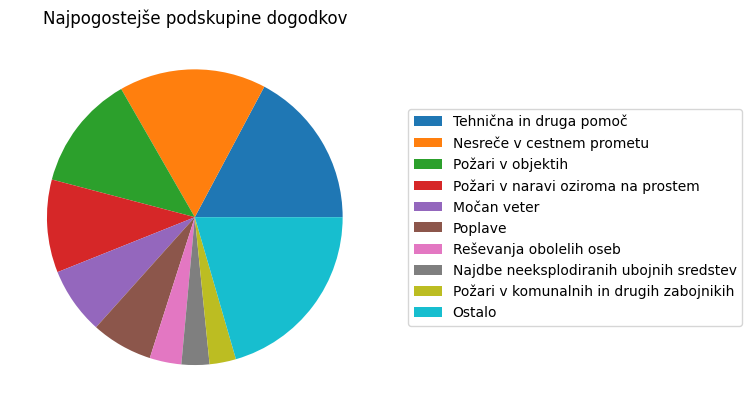

,stevilo
ime,
Tehnična in druga pomoč,30864
Nesreče v cestnem prometu,28845
Požari v objektih,22596
Požari v naravi oziroma na prostem,18222
Močan veter,13094
Poplave,12045
Reševanja obolelih oseb,6220
Najdbe neeksplodiranih ubojnih sredstev,5469
Požari v komunalnih in drugih zabojnikih,5190


In [3]:
def stisni_rep(tabela, stolpec_s_podatki, stolpec_z_imeni, dolzina_glave):
    """Obdrži prvih `dolzina_glave` vrstic, preostale pa
    strne v vrstico z imenom `"Ostalo"`"""
    glava = tabela.sort_values(by=stolpec_s_podatki, ascending=False).head(dolzina_glave)
    st_ostalih = tabela[stolpec_s_podatki].sum() - glava[stolpec_s_podatki].sum()
    return pd.concat(
        [
            glava, 
            pd.DataFrame(
                {
                    stolpec_s_podatki: [st_ostalih],
                    stolpec_z_imeni: ["Ostalo"]
                },
                index=[0]
            )
        ]
    )

# Združi dogodke po podskupinah in prešteje
stevila_po_podskupinah = dogodki.groupby(
    dogodki.dogodek.apply(id_podskupine_dogodka)
    ).size().rename_axis("podskupina")

# Ustvari objekt DataFrame
intervencije_po_podskupinah = pd.DataFrame(
    {"stevilo": stevila_po_podskupinah.sort_values(ascending=False)}
    )

# Poimenuje podskupine
intervencije_po_podskupinah["ime"] = intervencije_po_podskupinah.index.to_series().apply(ime_podskupine)

# Obdrži najpogostejše skupine, ostale združi pod "Ostalo"
najpogostejse_podskupine_dogodkov = stisni_rep(intervencije_po_podskupinah, "stevilo", "ime", 9)

# Izriše graf
najpogostejse_podskupine_dogodkov.plot(
    title="Najpogostejše podskupine dogodkov",
    kind="pie",
    labels=najpogostejse_podskupine_dogodkov.ime,
    y="stevilo",
    labeldistance=None,
    ylabel=""
)
plt.legend(loc="right", bbox_to_anchor=(2, 0.5))
plt.show()

# Prikaže tabelo s podatki
najpogostejse_podskupine_dogodkov.set_index("ime")[["stevilo"]]

### Ugotovitve

Skladno z mojimi predvidevanji je najpogostejši vzrok za posredovanje gasilcev gašenje požarov, presenetilo pa me je, da gašenje predstavlja manj kot tretjino njihovega dela. Gasilci pogosteje, kot sem pričakoval, posredujejo tudi pri prometnih in naravnih nesrečah, kot sta močno vetrovje in poplave.

## Intervencije skozi leta

Zanima me, kako se je število intervencij iz posameznih skupin spreminjalo tekom let. Rad bi tudi ugotovil, kako je kriza, povezana z epidemijo COVID-19 vplivala na število raznih nesreč.

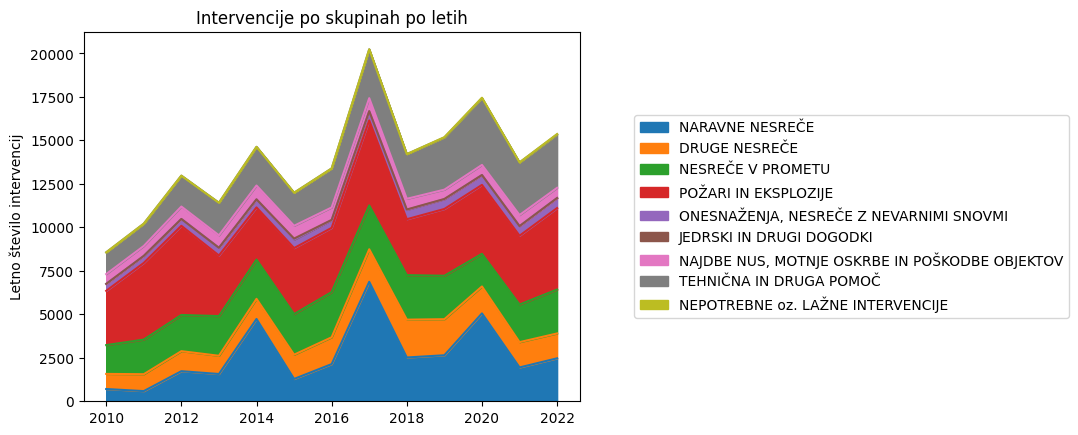

In [4]:
def pridobi_leto(niz):
    return datetime.fromisoformat(niz).year

def pridobi_mesec(niz):
    return datetime.fromisoformat(niz).month

def dataframe_iz_groupby_z_dvema_indeksoma(osnovni_dataframe, series_za_po_vrstici, series_za_po_stolpcu):
    '''V osnovnem `DataFrame`-u pogrupira vnose po vnešenima objektoma `Series` in prešteje število vnosov za posamezen par.
    Te pare nato predstav z DataFrame-om, ki ima po vrsticah in stolpcih primerne vrednosti.'''
    # Združi in prešteje vnose po obeh serijah, vrne objekt tipa Series z dvojnimi indeksi
    serija = osnovni_dataframe.groupby(
        by=[
            series_za_po_stolpcu,
            series_za_po_vrstici,
        ]
        ).size()

    # Poišče vse možnosti za indekse
    vsi_indeksi = serija.index.to_list()
    moznosti_vrstica, moznosti_stolpec = [], []
    for (indeks_stolpca, indeks_vrstice) in vsi_indeksi:
        if indeks_vrstice not in moznosti_vrstica:
            moznosti_vrstica.append(indeks_vrstice)
        if indeks_stolpca not in moznosti_stolpec:
            moznosti_stolpec.append(indeks_stolpca)
    
    # Ustvari in vrne DataFrame
    return pd.DataFrame(
            data={stolpec: serija[stolpec] for stolpec in moznosti_stolpec},
            index=moznosti_vrstica
        )

intervencije_po_letih = dataframe_iz_groupby_z_dvema_indeksoma(
    dogodki,
    dogodki.cas.apply(pridobi_leto),
    dogodki.dogodek.apply(id_skupine_dogodka)
    ).fillna(0).astype(int).rename(ime_skupine, axis="columns")     # Zamenja NaN z 0, pretvori vse floate v inte in preimenuje stolpce

# Izriše graf
intervencije_po_letih.plot(
    title="Intervencije po skupinah po letih",
    kind="area",
    ylabel="Letno število intervencij"
)
plt.legend(loc="right", bbox_to_anchor=(2, 0.5))
plt.show()

### Ugotovitve

Skupno število intervencij se načeloma, kot je razvidno iz grafa, v zadnjih dvanajstih letih povečuje. Proti mojim pričakovanjem pa predrugačen sistem delovanja družbe zaradi epidemije ni bistveno vplival na število gasilskih posredovanj. Na podlagi prikazanih podatkov sklepam, da je to zato, ker so najbolj nepredvidljiv faktor pri delu gasilcev naravne nesreče, število katerih med posameznimi leti tudi najbolj občutno niha.

Odločil sem se torej, da podrobneje raziščem še vzroke za sunkovito povečanje števila posredovanj pri naravnih nesrečah v letih 2014, 2017 in 2020.

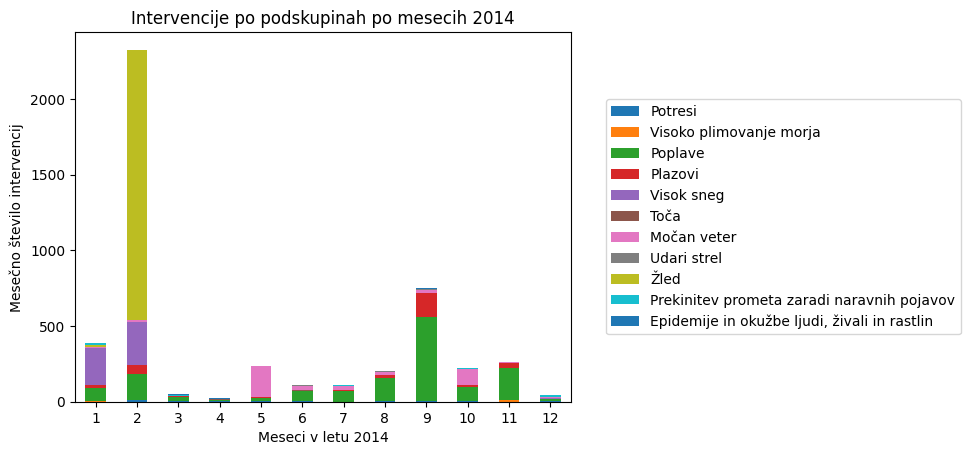

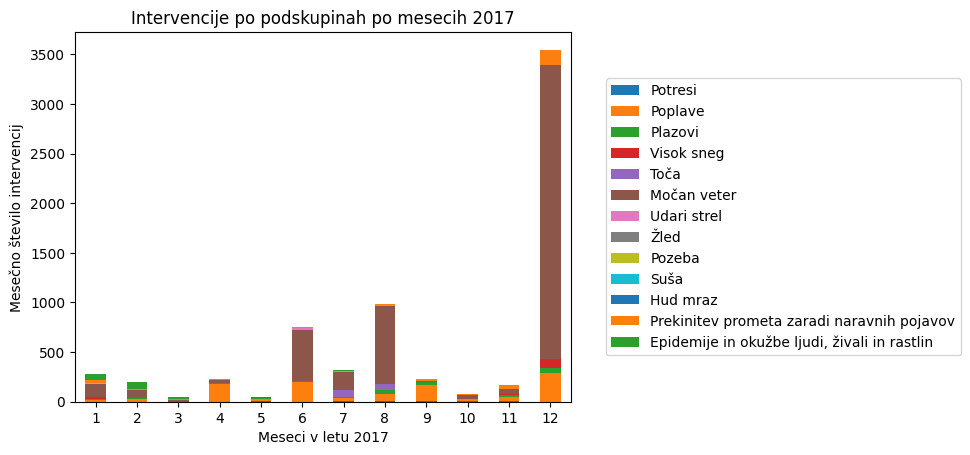

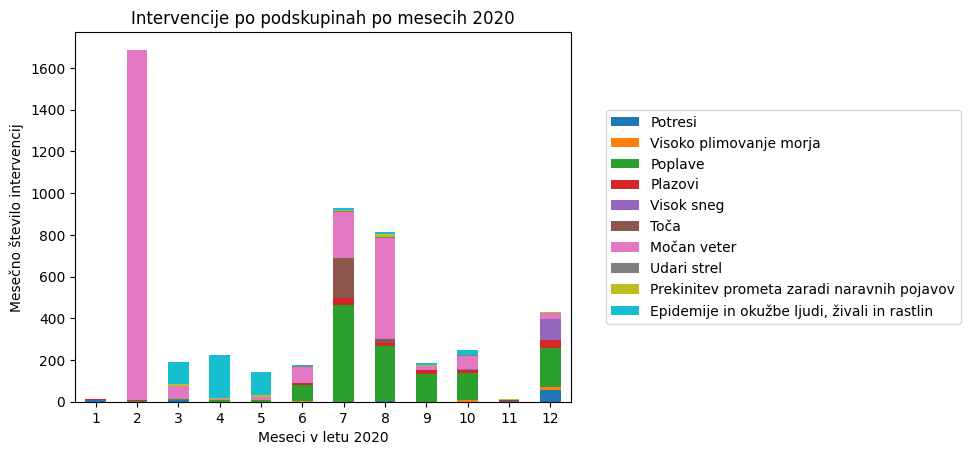

In [5]:
def prikazi_leto_po_mesecih_in_podskupinah(leto):
    '''Sestavi stolpični diagram števila intevencij po mesecih za
    posamezno leto. Pri tem z barvami ponazori, katerim podskupinam
    pripadajo.'''
    relevantni_dogodki = dogodki[(dogodki.cas.apply(pridobi_leto) == leto) & (dogodki.dogodek.apply(id_skupine_dogodka) == 10000)]
    relevantni_dogodki_po_mesecih = dataframe_iz_groupby_z_dvema_indeksoma(
        relevantni_dogodki,
        relevantni_dogodki.cas.apply(pridobi_mesec),
        relevantni_dogodki.dogodek.apply(id_podskupine_dogodka)
        ).fillna(0).astype(int).rename(ime_podskupine, axis="columns").sort_index()
    relevantni_dogodki_po_mesecih.plot(
        title=f"Intervencije po podskupinah po mesecih {leto}",
        kind="bar",
        stacked=True,
        xlabel=f"Meseci v letu {leto}",
        ylabel="Mesečno število intervencij"
    )
    plt.legend(loc="right", bbox_to_anchor=(1.8, 0.5))
    plt.xticks(rotation=0)
    plt.show()

for leto in [2014, 2017, 2020]:
    prikazi_leto_po_mesecih_in_podskupinah(leto)


Iz prikazanih podatkov lahko sklepamo, da imajo na gasilske intervencije najbolj občuten vpliv posledice nenadnih naravnih katastrof, kot so žled, poplave in močan veter, vpliv epidemije pa je v primerjavi z njimi zanemarljiv. 

## Intervencije po statističnih regijah

Zanima me, kako se skupine najpogostejših intervecij spreminjajo od regije do regije.

V ta namen bom potreboval nekaj dodatnih podatkov o samih občinah, ki jih lahko za začetek uvozim v novo tabelo. Poleg tega naložim tudi tabelo z ustreznimi indeksi občin iz _SPIN_-a in nekoliko popravim njihova imena, da lahko nato ujemajoči se tabeli združim.

In [6]:
podatki_o_obcinah = pd.read_csv("zajeti_podatki/csv/podatki_o_obcinah.csv")
obcine_iz_spina = pd.read_csv("zajeti_podatki/csv/obcine.csv")

def popravi_ime_obcine(ime):
    '''Spremeni ime občine iz formata uporabljenega v SPIN-u v zapis, kot je uporabljen na Wikipediji.'''
    ime = ime.casefold()
    ime = " - ".join(ime.split("-"))    # doda presledke okrog pomišljaja
    ime = ime.split(" ")
    for i in range(len(ime)):
        if not ime[i] in ["v", "ob", "na", "pri", "vas", "mesto", "polju", "goricah", "dolina"]:
            ime[i] = ime[i].capitalize()
    ime = " ".join(ime)
    ime = ime.replace("Sv.", "Sveta")
    ime = ime.replace("Slov.", "Slovenskih")
    ime = ime.replace("Kanal", "Kanal ob Soči")
    return ime

obcine_iz_spina["ime"] = obcine_iz_spina["ime"].apply(popravi_ime_obcine)
obcine = obcine_iz_spina.merge(podatki_o_obcinah, left_on="ime", right_on="obcina")
obcine = obcine.set_index(obcine.id)
obcine = obcine.drop(columns=["id", "ime"])
obcine

,obcina,povrsina,prebivalstvo,pokrajina,regija
id,,,,,
11026516,Ajdovščina,245.2,19418,Primorska,Goriška
11026524,Beltinci,62.2,8059,Prekmurje,Pomurska
11026532,Bled,72.3,7868,Gorenjska,Gorenjska
11026559,Bohinj,333.7,5145,Gorenjska,Gorenjska
11026567,Borovnica,42.3,4579,Notranjska,Osrednjeslovenska
...,...,...,...,...,...
24063488,Rečica ob Savinji,30.1,2287,Štajerska,Savinjska
24063496,Sveti Jurij v Slovenskih goricah,31.0,2114,Štajerska,Podravska
24063500,Šentrupert,49.0,2807,Dolenjska,Jugovzhodna


Poglejmo sedaj, kako se vrsta dela gasilcev razlikuje med statističnimi regijami Slovenije.

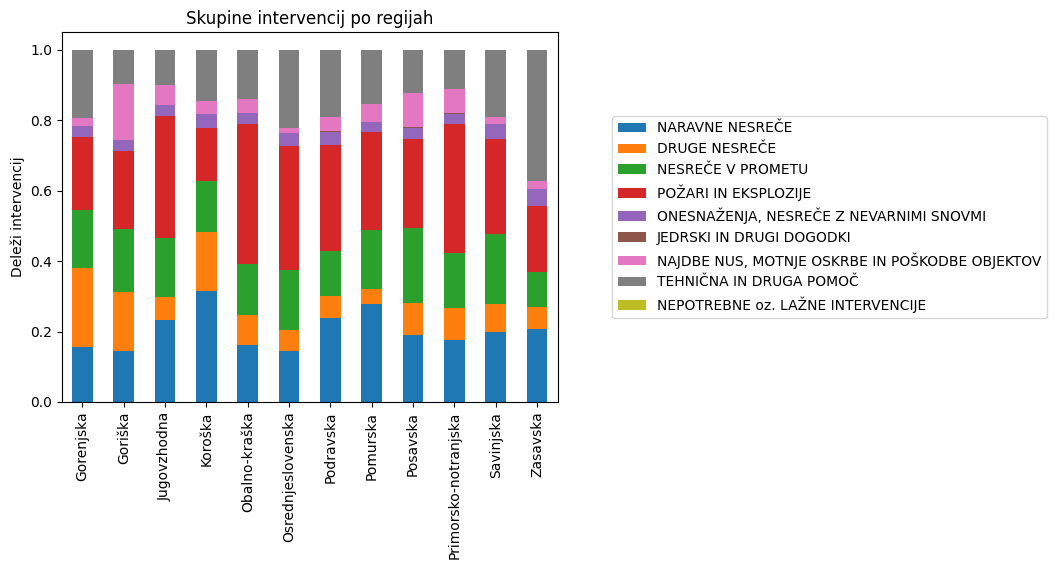

In [7]:
dogodki_z_regijami = dogodki.merge(obcine[["regija"]], left_on="obcina", right_on="id")
stevilo_dogodkov_po_skupinah_in_regijah = dataframe_iz_groupby_z_dvema_indeksoma(
    dogodki_z_regijami,
    dogodki_z_regijami.regija,
    dogodki_z_regijami.dogodek.apply(id_skupine_dogodka)
).fillna(0).astype(int).rename(ime_skupine, axis="columns")

# Podatke normaliziramo, da dobimo deleže
delez_dogodkov_po_skupinah_in_regijah = stevilo_dogodkov_po_skupinah_in_regijah.div(
    stevilo_dogodkov_po_skupinah_in_regijah.sum(axis=1),
    axis=0
    )

# Narišemo graf
delez_dogodkov_po_skupinah_in_regijah.plot(
        title=f"Skupine intervencij po regijah",
        kind="bar",
        stacked=True,
        ylabel="Deleži intervencij"
    )
plt.legend(loc="right", bbox_to_anchor=(2, 0.5))
plt.xticks(rotation=90)
plt.show()


### Ugotovitve

Deleži intervencij po skupinah so si med seboj načeloma dokaj podobni z nekaterimi precej smiselnimi izjemami. Na primer v Obalno-kraški regiji imajo relativno veliko požarov, na Koroškem imajo več naravnih nesreč kot so poplave in močan veter, na Goriškem pa najdejo največ neeksplodiranih ubojnih sredstev (NUS).

In [8]:
def najpogostejša_podskupina_za_regijo_in_skupino(regija, id_skupine):
    '''Vrne niz, v katerem pove najpogostejšo podskupino dogodkov v dani regiji.'''
    najpogostejsa = dogodki_z_regijami[
        (dogodki_z_regijami.regija == regija) & (dogodki_z_regijami.dogodek.apply(id_skupine_dogodka) == id_skupine)
        ].groupby(
            dogodki_z_regijami.dogodek.apply(id_podskupine_dogodka)
        ).size().sort_values(ascending=False).rename(ime_podskupine).index[0]
    return f'Najpogostejša podskupina v dani skupini za regijo "{regija}" je "{najpogostejsa}".'

print(najpogostejša_podskupina_za_regijo_in_skupino("Obalno-kraška", 40000))
print(najpogostejša_podskupina_za_regijo_in_skupino("Koroška", 10000))
print(najpogostejša_podskupina_za_regijo_in_skupino("Goriška", 70000))

Najpogostejša podskupina v dani skupini za regijo "Obalno-kraška" je "Požari v naravi oziroma na prostem".
Najpogostejša podskupina v dani skupini za regijo "Koroška" je "Poplave".
Najpogostejša podskupina v dani skupini za regijo "Goriška" je "Najdbe neeksplodiranih ubojnih sredstev".


## Odnos med velikostjo občine in številom intervencij

Za konec si poglejmo še, kako se skupno število intervencij spreminja z velikostjo občine in ali so morda kakšne občine, ki bistveno odstopajo od pričakovanih vrednosti. Za lažjo vizualizacijo podatkov bom te predstavil z metodo `scatter`, pri čemer bom za preglednost uporabil logaritemsko skalo.

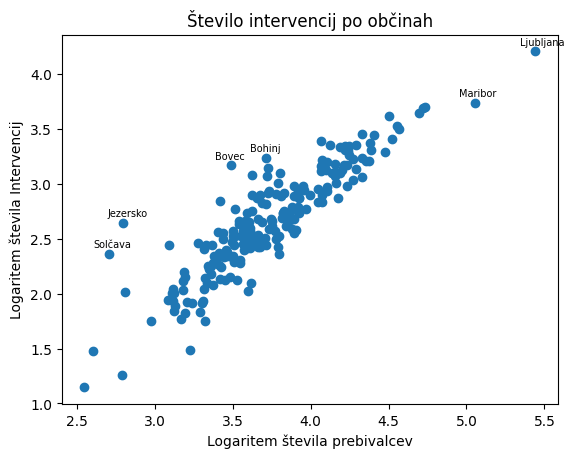

In [9]:
# Series z indeksi občin in ustreznimi števili dogodkov
stevilo_dogodkov_po_obcinah = dogodki.groupby(dogodki.obcina).size().rename("st_intervencij")

# Tabela, ki vsebuje še imena občin in števila prebivalcev
obcine_z_dogodki_in_prebivalstvom = pd.concat([obcine[["obcina", "prebivalstvo"]], stevilo_dogodkov_po_obcinah], axis=1)

# Definiramo sezname podatkov za prikaz z grafom
imena_obcin = obcine_z_dogodki_in_prebivalstvom.obcina.to_list()
x_seznam = [log10(preb) for preb in obcine_z_dogodki_in_prebivalstvom.prebivalstvo]
y_seznam = [log10(st) for st in obcine_z_dogodki_in_prebivalstvom.st_intervencij]

# Narišemo graf
plt.scatter(x_seznam, y_seznam)
plt.title("Število intervencij po občinah")
plt.xlabel("Logaritem števila prebivalcev")
plt.ylabel("Logaritem števila Intervencij")

# Da se izognemo prekrivanju podatkov, poimenujemo le občine z največjim
# številom prebivalcev ter občine z najvišjim številom intervencij na
# prebivalca (na logaritemski skali postane razmerje razlika)
for i in range(len(imena_obcin)):
    if (x_seznam[i] > 5) or (y_seznam[i] - x_seznam[i] > -0.5):
        plt.text(x_seznam[i] - 0.1, y_seznam[i] + 0.06, imena_obcin[i], fontdict={"size": 7})
plt.show()

### Ugotovitve

Kot se mi je zdelo smiselno, število intervencij praviloma narašča sorazmerno s številom prebivalcev v občini. Vseeno pa imamo nekaj občin, v katerih je bilo opaziti rahla odstopanja. Z nadaljno analizo podatkov sem ugotovil, da gre za občine v goratih predelih, kjer večji del intervencij predstavljajo nesreče v gorah.

In [10]:
obcine_z_dogodki_in_prebivalstvom["na_prebivalca"] = obcine_z_dogodki_in_prebivalstvom.st_intervencij / obcine_z_dogodki_in_prebivalstvom.prebivalstvo

def id_obcine(ime_obcine):
    '''Iz imena občine pridobi njen indeks'''
    return obcine[obcine.obcina == ime_obcine].index[0]

def najpogostejsa_podskupina(ime_obcine):
    '''Vrne niz, ki omeni najpogostejšo podskupino v dani
    občini in odstotek intervencij, ki ga ta predstavlja.'''
    po_podskupinah = dogodki[
        dogodki.obcina == id_obcine(ime_obcine)
        ].groupby(
            dogodki.dogodek.apply(id_podskupine_dogodka)            # Združi po podskupinah
        ).size().sort_values(ascending=False)
    delezi = po_podskupinah / po_podskupinah.sum()
    sifra_podskupine, delez = delezi.index[0], delezi.iloc[0]       # Vrne vrednosti za najpogostejšo podskupino
    podskupina = ime_podskupine(sifra_podskupine)
    odstotek = round(100 * delez, 1)
    return f'V občini {ime_obcine} največkrat posredujejo pri dogodkih iz podskupine "{podskupina}", kar predstavlja {odstotek}% njihovega dela.'

for obcina in ["Solčava", "Jezersko", "Bovec", "Bohinj"]:
    print(najpogostejsa_podskupina(obcina))


V občini Solčava največkrat posredujejo pri dogodkih iz podskupine "Nesreče v gorah", kar predstavlja 51.5% njihovega dela.
V občini Jezersko največkrat posredujejo pri dogodkih iz podskupine "Močan veter", kar predstavlja 36.8% njihovega dela.
V občini Bovec največkrat posredujejo pri dogodkih iz podskupine "Nesreče v gorah", kar predstavlja 25.6% njihovega dela.
V občini Bohinj največkrat posredujejo pri dogodkih iz podskupine "Nesreče v gorah", kar predstavlja 34.0% njihovega dela.


## Naivni Bayesov klasifikator

Za konec me zanima še, ali lahko z metodo naivnega Bayesovega klasifikatorja sestavim funkcijo, ki bo iz opisa dogodka smiselno določila, v katero podskupino sodi. V ta namen bom najprej opise pretvoril v serije korenov besed.

In [11]:
def koren_besede(beseda):
    '''Iz dane beseda izlušči koren. Če v besedi ni črk, vrne `"$"`.'''
    beseda = "".join(znak for znak in beseda if znak.isalpha())
    beseda = beseda.casefold()
    beseda = beseda.rstrip("aeiou")
    for konec in ["l", "em", "om", "ev", "ov", "ih", "am", "ah", "eg", "im"]:
        if beseda.endswith(konec):
            beseda = beseda[:-len(konec)]
            break
    return beseda if beseda else "$"

def koreni_besed(niz):
    '''Dan niz razbije na besede in vrne objekt `Series` z njihovimi koreni.'''
    if not niz:
        return pd.Series([], dtype=str)
    else:
        return pd.Series([koren_besede(beseda) for beseda in niz.split()], dtype=str)

In [12]:
# Ocenimo, kolikšna je verjetnost, da dogodek pripada posamezni podskupini
verjetnosti_podskupin = stevila_po_podskupinah / stevila_po_podskupinah.sum()

In [13]:
# Ker z vsemi podatki to traja več minut, se lahko za demonstracijo omejimo na
# manjše število dogodkov
STEVILO_DOGODKOV_ZA_KLASIFIKATOR = 10000

# Tabela z vsemi pari (zaporedno število dogodka, koren)
tabela_vseh_pojavitev_korenov = dogodki.head(STEVILO_DOGODKOV_ZA_KLASIFIKATOR).opis.apply(
        koreni_besed                                    # Vsakemu dogodku priredi Series korenov in to združi v DataFrame
    ).unstack(                                          # Pretvori tabelo v series z dvojnim indeksom (zap. št. besede, zap. št. dogodka)
    ).reset_index(                                      # Poenostavi na enojen indeks
    )[                                                  # Obdrži le stolpca s podskupinami in koreni
        ["level_1", 0]
    ].rename(                                           # Ju ustrezno preimenuje
        {"level_1": "dogodek", 0: "koren"},
        axis=1
    ).dropna()                                          # Izpusti vrednosti NaN

# Prejšnji tabeli dodamo podskupine dogodkov
tabela_s_podskupinami = tabela_vseh_pojavitev_korenov.merge(
    dogodki.dogodek.apply(id_podskupine_dogodka).rename("podskupina"),
    left_on="dogodek",
    right_index=True
    )

# Tabela, kjer so vrstice koreni, stolpci podskupine, na poljih pa so
# verjetnosti, da se pri dani podskupini pojavi posamezen koren
verjetnosti_korenov_pri_podskupinah = (
    tabela_s_podskupinami.groupby(
        ["podskupina", "koren"]
        ).size() / stevila_po_podskupinah               # Poračuna verjetnosti
    ).unstack(                                          # Pretvori nazaj v tabelo
    ).transpose(                                        # Transponira tabelo, da dobimo korene za vrstice
    ).fillna(                                           # Na vrednosti NaN vnese zelo majhno pozitivno število
        1 / len(dogodki)
    ).reset_index()                                     # Ponastavi indekse, da so koreni svoj stolpec in ne indeksni

In [14]:
def podskupina_iz_opisa(opis):
    '''Iz podanega opisa s pomočjo metode naivnega Bayesovega klasifikatorja
    poišče najverjetnejšo podskupino, ki ji opisan dogodek pripada'''
    koreni = koreni_besed(opis)
    verjetnosti = verjetnosti_korenov_pri_podskupinah[
        verjetnosti_korenov_pri_podskupinah.koren.isin(koreni)
    ].product(
        numeric_only=True
    ) * verjetnosti_podskupin
    return ime_podskupine(verjetnosti.sort_values(ascending=False).index[0])

S tem smo uspešno implementirali naivni Bayesov klasifikator. Njegovo delovanje lahko preverimo na nekaj nizih, ki niso del zajetih podatkov. Spodaj je nekaj opisov iz iste spletne strani, ki so bili objavljeni po tem, ko sem sam pobral podatke.

In [15]:
testni_nizi = [
    """Ob 9.11 sta v Orehovljah, občina Miren - Kostanjevica, pripadnika Državne enote za varstvo pred NUS
    Severnoprimorske regije odstranila na varno najdeno topovsko granato, kalibra 75 mm, mase 7 kg, italijanske
    izdelave iz obdobja 1. svetovne vojne""",
    """Ob 15.41 je v Dokležovju, občina Beltinci, voznik z osebnim vozilom trčil v drog električne napeljave,
    pri čemer se je vozilo prevrnilo na bok. Gasilci PGD Murska Sobota so zavarovali kraj dogodka, s tehničnim
    posegom omogočili reševalcem dostop do ukleščene poškodovane osebe in očistili kraj nesreče.""",
    """Ob 15.29 je na Tovarniški cesti v Ajdovščini zagorelo na prikolici tovornjaka. Požar je delno pogasil
    voznik tovornjaka, dokončno pa gasilci GRC Ajdovščina.""",
    """Ob 12.48 si je na planini Koren v občini Kamnik pohodnik poškodoval gleženj. Posredovali so gorski
    reševalci GRS Kamnik, dežurna ekipa za reševanje v gorah GRS Brnik in helikopter SV. Helikopter je
    poškodovanca prepeljal v SB Jesenice."""
]
for niz in testni_nizi:
    print(
f"""
====================================================
OPIS: {niz}
PREDVIDENA PODSKUPINA: {podskupina_iz_opisa(niz)}
====================================================""")



OPIS: Ob 9.11 sta v Orehovljah, občina Miren - Kostanjevica, pripadnika Državne enote za varstvo pred NUS
    Severnoprimorske regije odstranila na varno najdeno topovsko granato, kalibra 75 mm, mase 7 kg, italijanske
    izdelave iz obdobja 1. svetovne vojne
PREDVIDENA PODSKUPINA: Najdbe neeksplodiranih ubojnih sredstev

OPIS: Ob 15.41 je v Dokležovju, občina Beltinci, voznik z osebnim vozilom trčil v drog električne napeljave,
    pri čemer se je vozilo prevrnilo na bok. Gasilci PGD Murska Sobota so zavarovali kraj dogodka, s tehničnim
    posegom omogočili reševalcem dostop do ukleščene poškodovane osebe in očistili kraj nesreče.
PREDVIDENA PODSKUPINA: Nesreče v cestnem prometu

OPIS: Ob 15.29 je na Tovarniški cesti v Ajdovščini zagorelo na prikolici tovornjaka. Požar je delno pogasil
    voznik tovornjaka, dokončno pa gasilci GRC Ajdovščina.
PREDVIDENA PODSKUPINA: Požari na prometnih sredstvih

OPIS: Ob 12.48 si je na planini Koren v občini Kamnik pohodnik poškodoval gleženj. Posr

### Ugotovitve

Kot je moč sklepati iz zgornjih primerov, naš klasifikator deluje precej dobro, saj je pri vseh opisih podal smiselne in večinoma pravilne podskupine.